# The Monte Carlo Markov Chain (MCMC)

Last time, we noticed that the grid approximation algorithm starts to collapse when try to fit models with three or more parameters. We have a dilemma: either we use an extremely fine-grain to approximate the posterior and blast our computation time through the roof. Or, we use an course-grain and run the risk of missing the most important features of the posterior.

One problem with grid approximation is that we spend a lot of time computing in pretty boring regions of the posterior. Take a look at this posterior. Much of the space is basically flat at 0 or nearly 0 posterior probability.



![](https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/3D%20mixture.png)



What would be a better strategy? What if we could concentrate most of our computational time in the mountains and spent just a little bit of computational time on the prairies around them? Or, more generally, it would be smart to spend our computational energy measuring the posterior in proportion to how high the posterior is.

I'll introduce **m**onte **c**arlo **m**arkov **c**hain (MCMC) with a parable. Imagine a skateboard park with a massive bowl at the center. The skateboard park has been carefully measured so we have a grid of x and y coordinates that covers each point in the park. A skateboarder rides around the bowl, flying up the sides, dropping back down into the center, making tunes in random directions. They skate for an hour. Every few seconds, an aerial drone stationed directly above the bowl takes a snapshot of the skateboarder. Thousands of snapshots are recorded. In each one, we record the x and y coordinates of the skateboarder. After the hour is over, we compile a list of all the x and y coordinates.

In this parable, the depth of the bowl represents areas with high posterior probability. The location of the skateboard with respect to x and y represents two different parameter values, perhaps `independent error rate` is on one axis and `conformist error rate` is on another. It turns out that the frequency distribution of locations will roughly correspond to the depth of the bowl. Or, simply, the skateboarder will get their picture taken most often when they are in the center of the bowl. They will get their picture taken fairly often in the region between the rim and the center. And they will get their picture taken least often at the rim. Why? Well, they are usually only at the rim for a split second before they turn around and go back. But quite often they are flying through the center of the bowl. The laws of gravity and momentum help ensure this is true.

Okay how does this wacky parable help us? Well, it means we only need a finite number of snapshots to get a good approximation of the posterior distribution. As we add more parameters to model, the number of snapshots doesn't grow out of control. Instead of exploring every possible combination of values, we spend more of our time looking at the interesting values (those close to the center). But instead of only looking for the best, we also spend some time exploring the values at the edges (to get a sense of uncertainty).

If you reading the notes from home, I suggest you stop and watch 10 minutes (minute 28-38) of [this video](https://www.youtube.com/watch?v=rZk2FqX2XnY&list=PLDcUM9US4XdPz-KxHM4XHt7uUVGWWVSus&index=8). In class, we spent time trying to get a visual intuition for Monte Carlo Markov Chains via animation. That is hard to do with the notes. The animation tool used in that video can be found here and we explored it in class.

https://chi-feng.github.io/mcmc-demo/app.html?algorithm=HamiltonianMC&target=standard

Designing and implementing monte carlo markov chain algorithms is really tough. So we've handed that work off to a package called PyMC (pronounded pie-em-ce).

# Introducing PyMC

PyMC is designed like a box of Legos. It gives you a bunch of flexible pieces. Most of them snap together easily. A few of them don't. Once you get used to building the lego sets by following directions, you can start rearranging the pieces together to build novel and interesting things. It will automate a lot of difficult processes, such as writing MCMC algorithms by hand, performing numerical optimization, calculating derivatives, building custom visualization tools. We get to dedicate nearly all our attention to just build the models.

One of the big tradeoffs I always face in my class is how many different packages to teach. Every additional package is a lot of memorization and reference guides to keep track off. I would prefer if we could just get comfortable with a very small batch of packages and do everything we want. But, unfortnately, we spend a more time writing very intricate algorithms by hand. It would be error prone and it would distract attention for your goals. So if you can forgive me for giving you one more package you have to learn, then we can accomplish a lot more.

We import it like this:

In [1]:
import pymc as pm

## Simple binomial problems in pymc

Let's start looking at examples of PyMC code. We feed PyMC our prior and our likelihood function using a `with pm.Model as NAME_OF_MODEL`. Notice the indentation. The `with` structure is a way of grouping a bunch of information under a single object, this time called `model_0`.

In [2]:
with pm.Model() as model_0:
    
    # --priors--
    # beta is another name for a flat prior
    # that assigns equal probability to every p in
    # between 0 and 1.
    
    p = pm.Beta('p',alpha=1,beta=1)
    
    # --likelihood--
    # this the pymc syntax equivalent for stats.binom
    # n is still n
    # p is still p
    # but k has been replaced with 'observed'
    
    y = pm.Binomial('y',n=8,p=p,observed=6)

There are some rules to PyMC. First, every probability distribution needs a name. That's the bit in quotation makes that makes the first argument. These names are saved and referenced later when we call visualization functions. Second, probability distribution take parameters just like scipy distributions do. Sometimes the name of the parameters changes - in scipy, we had beta(a,b) and here we have beta(alpha,beta). We have a [reference](https://www.pymc.io/projects/docs/en/stable/api/distributions.html) that lists all the various distributions and the arguments they receive. Try to find our friends Normal, Gamma, Binomial, Exponential and Beta.

All probability distributions are priors until we say otherwise. When we pass `observed=` to any probability distribution, we turn it into a likelihood distribution. So PyMC knows that `Beta(1,1)` is the prior for the `p` parameter and the `p` parameter is used in calculating the likelihood of the data.

You can run the cell with just this information in it to see if everything is well defined. Notice that this is the same Bayesian estimation of the lady tasting tea from before. But we only really need two lines of code to express it: the prior and the likelihood. No need to define a grid. No need to manually normalize things.

In [ ]:
with model_0:
    # estimation algorithm
    # pm.sample() just uses all the default settings
    # the package automatically detects which
    # estimation algorithm will work for your model
    # and tunes the algorithm for best performance
    # rarely, if ever, should use anything but the default settings
    
    trace = pm.sample()

Once we check to make sure our model is well-defined, we can do `trace = pm.sample()`. `trace` is the name of the object we store all the information into once we want to analyze the results later. `pm.sample()` is the command to activate the monte carlo markov chain. It will usually call it "NUTS" which is a sub-class of monte carlo markov chain that works well on most problems. If NUTS is not the right algorithm for you model, it will automatically infer that and call a better algorithm.

Finally, we have a plotting package called `arviz` which is designed to work with `trace`s our of PyMC. Try `plot_posterior` to look at our graph.

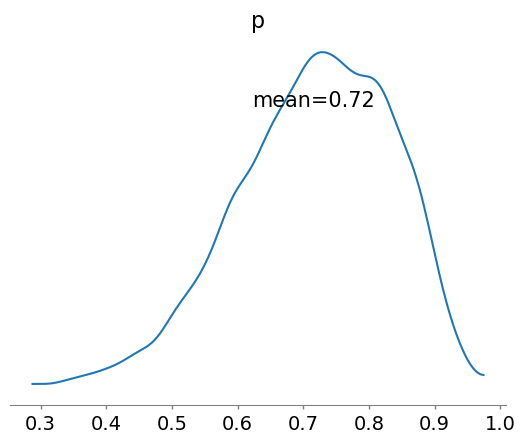

In [60]:
import arviz as az

# I'm hiding the hdi so we don't have to talk about it right now
# it is harmless though so feel free to omit the second argument.

az.plot_posterior(trace,hdi_prob='hide');

This should look familiar - it's the same posterior distribution chart we got from the grid approximation algorithm in unit one. Posterior plots will look at little wiggly when we use Monte Carlo Markov Chains. That's perfectly normal.

## Adjusting priors

We can easily adjust our priors using this software. Here is an example.

In [5]:
with pm.Model() as model_1:
    
    # you can play around with different priors
    # I switched out the uniform distribution for a beta
    # that puts more credibility toward medium values of p
    # and less credibility to extreme values of p
    
    p = pm.Beta('p',alpha=4,beta=2)
    
    y = pm.Binomial('y',n=8,p=p,observed=6)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


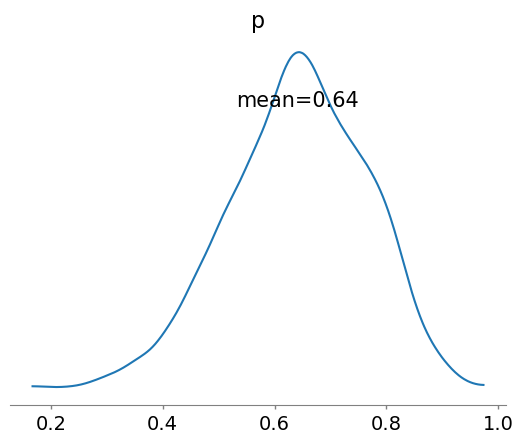

In [ ]:
az.plot_posterior(trace);

# Mixture models in PyMC

Now that we have some familiarity with the mechanics of PyMC and Monte Carlo Markov Chains, we can revisit the problem we got stuck on last lecture - how to estimate a three-parameter model? Let's reload our data.

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/Asch_experiment_1_data"

data = pd.read_csv(url)
data_treatment = data[data.treatment == 1]
mistakes_treatment = data_treatment.mistakes.values

Here's what a mixture model looks like in PyMC.

In [40]:
with pm.Model() as model_2:

    # mixture weights

    w = pm.Dirichlet('w',[1,1])

    # mixture components priors

    p0 = pm.Beta('p0',alpha=1,beta=1) # independent component
    p1 = pm.Beta('p1',alpha=1,beta=1) # conformist component

    # specifying the mixture components

    components = [pm.Binomial.dist(n=12,p=p0),pm.Binomial.dist(n=12,p=p1)]

    # likelihood

    y = pm.Mixture('error',w=w,comp_dists=components,observed=mistakes_treatment)

Let's break this code down into parts.

1. We have three priors. One of them is for the mixture weight - how many independents vs how many conformists? It is specified as new distribution, the Dirichlet. I'll explain the Dirichlet in due time. But for now know that the `Dirichlet(1,1)` is equivalent to the `beta(1,1)`. The other two priors are for the error rate of each respective group.

2. We have a `pm.Mixture()` function for a likelihood. Instead of writing our own mixture likelihood by hand, PyMC will automatically build one. The advantage of `pm.Mixture` this is that we can write fairly big mixtures (3, 4, or more components in the mixture) without much work. The unit 2 assignment will have you exploit this power. 

3. The mixture need to take in a list of component distributions, `comp_dists`, which we supplied on the line above. Each component is a binomial distribution. There is a quirk - we have to add the `.dist` method to the Binomials. `.dist` is just how you access something like the raw underlying distribution so other parts of the program can manipulate it. 

## Debugging a model

PyMC can be frusturating to use because all the components are specialized and don't work like usual python functions. When working with complicated numpy and scipy based routines, we noticed that we could understand our code a lot better by running each function individually before stitching them together. Could we debug PyMC models the same way?

In [9]:
pm.Binomial('error',n=8,p=0.5)

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

No. 

PyMC objects need to be inside a context stack. In other words, the `with pm.Model()` tag that starts our model block. You should think about PyMC models as subprograms that exist below or outside the main Python environment. They use a different style of programming than regular Python. In normal python, each function does something immediately upon being called. With PyMC, we are specifying a blueprint for a program. Once we ask it to `pm.sample()`, it rewrites our program in a more efficient way and only then does it run the numbers.

We do have other tools to debug or understand what is happening inside our model. We can draw samples from any distribution. This is like the `.rvs()` method of scipy. 

In [42]:
pm.draw(y)

array([0, 7, 0, 0, 0, 1, 0, 1, 5, 6, 6, 0, 3, 5, 1, 0, 0, 0, 0, 0, 3, 5,
       0, 5, 6, 4, 3, 2, 0, 1, 6, 4, 0, 1, 0, 3, 2, 3, 3, 2, 0, 6, 7, 4,
       5, 0, 4, 3, 1, 2], dtype=int64)

We have use the draw function to quickly visualize what each of our priors looks like. For example, let's double check `beta(1,1)` is really uniform and between $[0, 1]$.

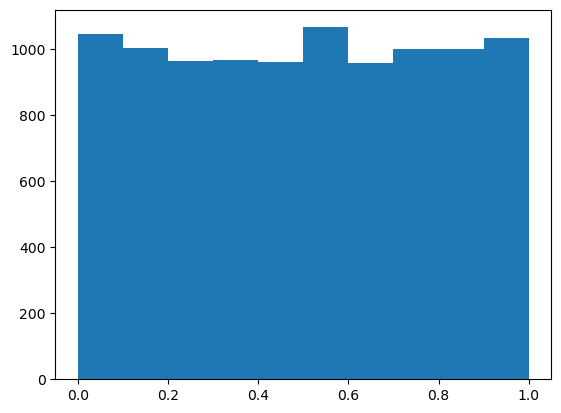

In [57]:
import matplotlib.pyplot as plt

samples = pm.draw(p0,draws=10000)
plt.hist(samples);

We have use the draw function to visualize what the priors and the likelihood jointly predict about the data. These samples follow the entire logic of the Bayesian model - first we sample parameters from our priors. Then we simulate data, using those parameters. This is a great tool for figuring out whether your PyMC model follows your intentions.

weights: [0.04951935 0.95048065]
independent error rate: 0.7052263665544336
conformist error rate: 0.9592298450171834


<BarContainer object of 13 artists>

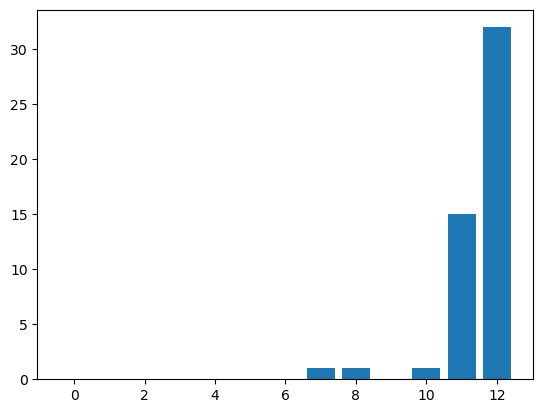

In [55]:
data_sample,w_sample,p0_sample,p1_sample = pm.draw([y,w,p0,p1])

print("weights: " + str(w_sample))
print("independent error rate: " + str(p0_sample))
print("conformist error rate: " + str(p1_sample))

data_sample = list(data_sample)

# counting structure

outcomes = range(13)
counts = []
    
for i in outcomes:

    matches = data_sample.count(i)
    counts.append(matches)
    
# plotting structure

plt.bar(outcomes,counts)

Take a few draws and see if the results seem intuitive. If you passed your mixture simulation those parameters, would you expect to get a bar graph of that shape?

## Monte Carlo Markov Chain Convergence

It feels like our model is working properly. Now we are ready to estimate it. Let the MCMC begin.

In [58]:
with model_2:
    trace_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, p0, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


It gives us two warnings:

- it is complaining about somthing called `rhat` and says this indicates problems. 
- it is complaining about something called 'effective sample size per chain' and claims it is smaller than 100.

Not good. 

Monte Carlo Markov Chain can sometimes be a brittle algorithm. Sometimes our intrepid skateboarder falls down, gets stuck in a hole, or gets distracted and wonders off. To compensate for that, modern algorithms always send in two or more skateboarders to map out the posterior. If they all come back and give us the same map, that suggests all is well. It would be surprising if two explorers both made the same mistakes.

`rhat` is a measure of how well multiple chains agree. When it is 1, they agree very well. When it is any other number, there are disprecancies between the maps returned by our explorers. In those cases, our map of the posterior might be unreliable. We can see the `rhat` number in the last column of the summary table.

In [68]:
az.summary(trace_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.551,0.120,0.314,0.746,0.045,0.034,8.0,31.0,1.41
w[1],0.449,0.120,0.254,0.686,0.045,0.035,8.0,31.0,1.41
p0,0.247,0.227,0.073,0.680,0.112,0.086,7.0,32.0,1.53
p1,0.505,0.227,0.086,0.707,0.112,0.085,7.0,29.0,1.53


Those are very high.

It is easier to understand if we look at plots of the paths that the Markov Chains took. `az.plot_trace` provides a visualization of the problem. On the left, we have a familiar depict of the posterior distribution but seperated out across 4 chains (or 2, in google colab it runs two chains). The chains do not agree. In most cases, `p0` is centered around 0.1 while `p1` is centered around 0.6. However, in one case, they are flipped. 

The lack of convergence throws our summaries off. In the summary table above, it says the mean error rate of `p0` is around 0.25. That cannot be right. In the picture below, the mean is near to `0.1` or `0.6`.

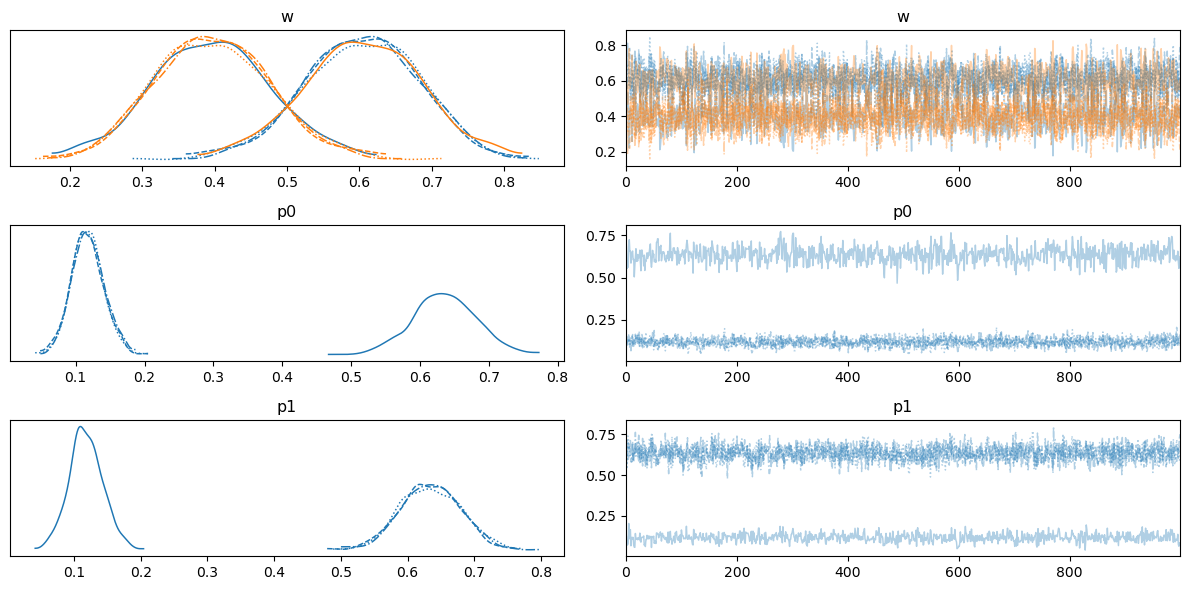

In [93]:
az.plot_trace(trace_2)
plt.tight_layout();

We can get an even better understanding of the problem if we look at the posteriors generated by the grid search from last lecture. Grid approximation does not suffer from convergence issues. If you have the patience, it will return a picture of your posterior. We can see that there are two different regions of high posterior. Those regions are also mirror images of each other. In the first, the conformist error rate is high while independents is low. In the other, the roles of flipped. Now "independents" make all the mistakes and "conformists" get it right.


![](https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/3D%20mixture.png)

Our Monte Carlo Markov Chains fail to converge because they are exploring different hills.

## Regularizing priors

Is there a way we could give our model just a bit more structure to generate convergence? One clue comes from the 3-dimensional map above. The posterior distribution where the "independents" make all the mistakes is a bit silly. What we mean when we talk about independents is just those people who don't make very many mistakes. So we expect the `p0`, the independent's error rate to be small. If we could just give the markov chains a gentle push toward one of the hills, rather than the other, we could ensure convergence in this problem.

One way to give our posterior a gentle push is with the priors. Priors normally encode prior knowledge. But they can also have another function - providing some regulation on the possible path of the monte carlo markov chain. So long as the priors are very gentle, they will not bias our resulting estimates. But they can smooth out a variety of algorithmic problems. These are called regularizing priors. They are extremely common in more delicate machine learning problem. Sometimes a model cannot learn the right answer until we give it a tiny clue. Then it solves it with ease.

So let's fix the prior for the independents to give it a push toward low error rates while we push the conformists toward high error rates. We'll show how this strategy works by reusing last lectures grid approximation algorithm first.

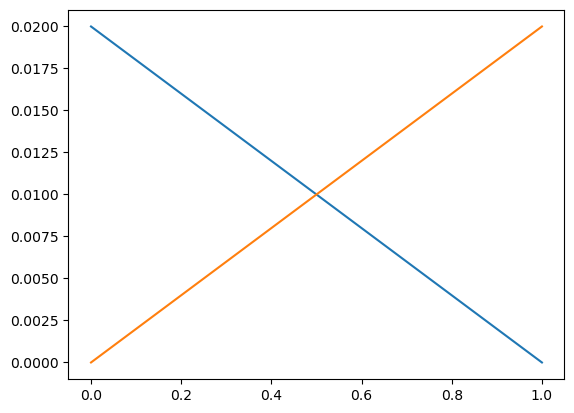

In [79]:
import numpy as np
import scipy.stats as stats

rate = 0.5
n = 12

independents_grid = np.linspace(0,1,100)
conformist_grid = np.linspace(0,1,100)

ind_prior = stats.beta(1,2).pdf(independents_grid)
ind_prior = ind_prior / sum(ind_prior)

con_prior = stats.beta(2,1).pdf(conformist_grid)
con_prior = con_prior / sum(con_prior)

plt.plot(independents_grid, ind_prior)
plt.plot(conformist_grid,con_prior)

In [82]:
def mixture_likelihood(data,rate,independents_p,conformist_p,n):
    '''
    Calculates the likelihood the data, assuming a mixture of two binomial distributions.

    data - an array or list with integer entries.
    rate - what proportion of the subjects should be 
    independents, the rest are conformists.
    independents_p - the probability of a mistake from an independent.
    conformist_p - the probability of a mistake from a conformist.
    n - the number of critical trials in the experiment.
    '''

    ll1 = rate*stats.binom(n=n,p=independents_p).pmf(data)
    ll2 = (1-rate)*stats.binom(n=n,p=conformist_p).pmf(data)

    return np.prod(ll1 + ll2)

posterior_table = []

for row in range(100):

    posterior_row = []

    for column in range(100):

        p1 = independents_grid[row]
        p2 = conformist_grid[column]
        prior1 = ind_prior[row]
        prior2 = con_prior[column]

        likelihood = mixture_likelihood(mistakes_treatment,rate,p1,p2,n)

        posterior = likelihood * prior1 * prior2
        posterior_row.append(posterior)

    posterior_table.append(posterior_row)

posterior_table = np.array(posterior_table)
posterior_table = posterior_table / np.sum(posterior_table)
posterior_distribution = pd.DataFrame(posterior_table,columns=independents_grid,index=conformist_grid)

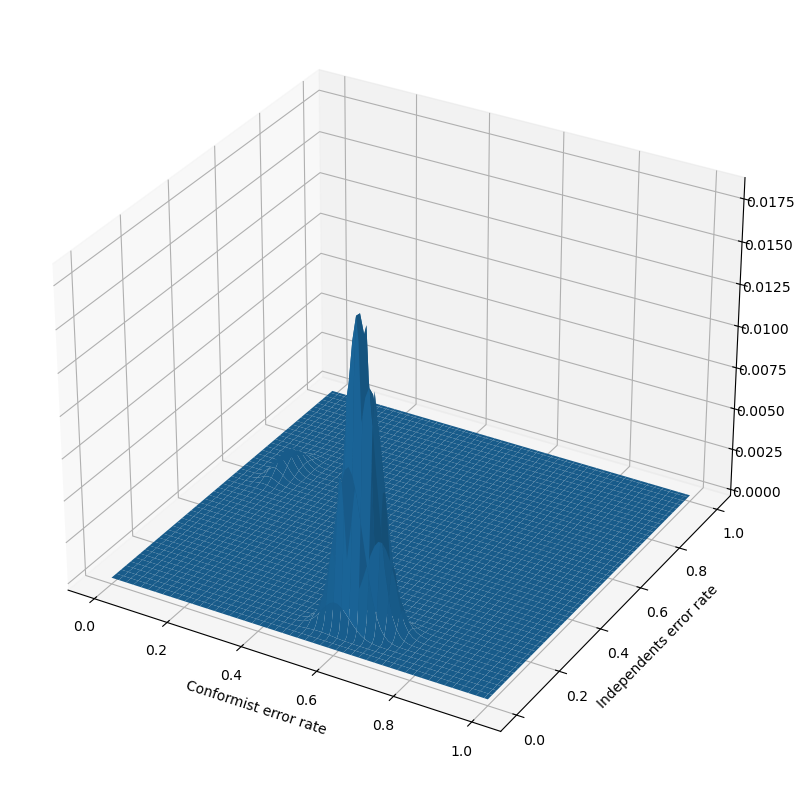

In [83]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(10,10))

x_coord, y_coord = np.meshgrid(independents_grid,conformist_grid)

surf = ax.plot_surface(x_coord, y_coord, posterior_table)
plt.ylabel("Independents error rate")
plt.xlabel("Conformist error rate");

This small adjustment to the prior squishes the second hill. It becomes a mere bump in the rug. Now our markov chains will tend to stay out of the that region (this solution can fail occassionally. If the initial location of the chain just happens to end up in that hill or the model becomes very complicated, it is still possible to end up in there.)

Our PyMC model fares much better - no warnings.

In [74]:
with pm.Model() as model_3:

    # mixture weights

    w = pm.Dirichlet('w',[1,1])

    # mixture components

    p0 = pm.Beta('p0',1,2) # independent component
    p1 = pm.Beta('p1',2,1) # conformist component
    components = [pm.Binomial.dist(n=12,p=p0),pm.Binomial.dist(n=12,p=p1)]

    # likelihood

    y = pm.Mixture('error',w=w,comp_dists=components,observed=mistakes_treatment)

    trace_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, p0, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


And the trace plots look better. So this is what a PyMC model looks like when everything is working properly.

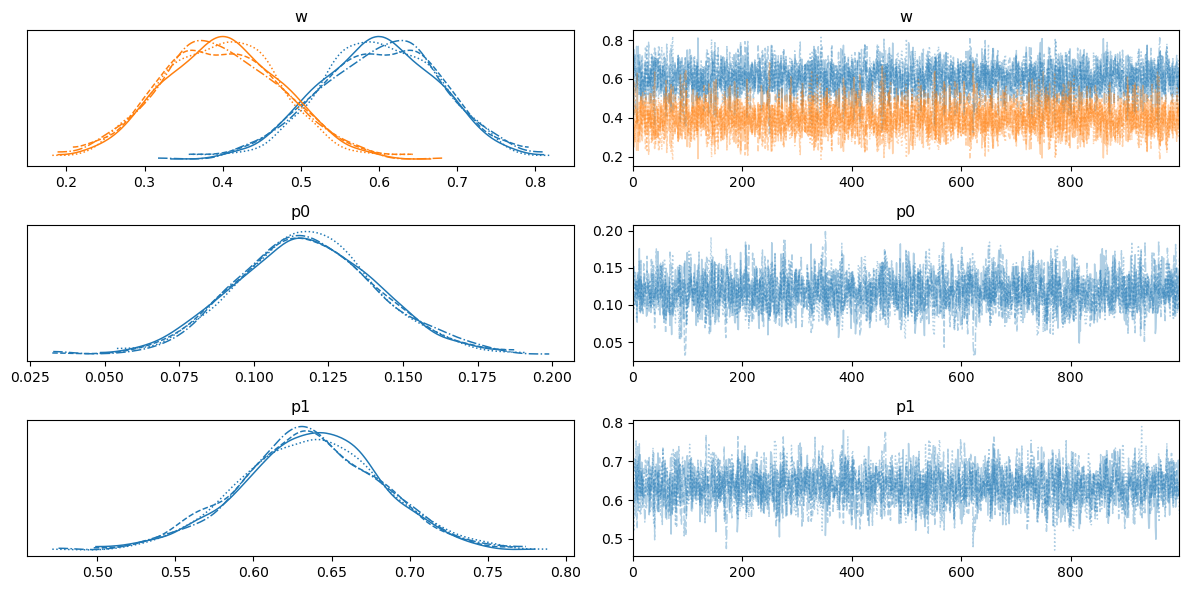

In [91]:
az.plot_trace(trace_3)
plt.tight_layout();

## Understanding the model ouput

We have two techniques to understand what our model has learned. The first is plotting the posteriors. We've already seen a few examples of that. The second is to draw out new predictions from the posterior. 

If we were going to run the experiment a second time, what should we expect? Our posterior distribution allows us to make new predictions. To generate predictions from a posterior, we use:

In [108]:
with model_3:
    predictive_trace = pm.sample_posterior_predictive(trace_3)

Sampling: [error]


`predictive_trace` is a strange Python object. It's like a little booklet summarizing everything about the model. You can click on the drop down arrows to open up sections of the booklet. There is a ton of information here. In this course, we'll always just open up `posterior_predictive` (ignoring `observed_data`). We are interested in the "Data variable" called `error`.

In [109]:
predictive_trace

Inference data with groups:
	> posterior_predictive
	> observed_data

We can use a syntax like this to access upsections of the `predictive_trace`. Here we have thousands of predictions, divided up into 4 groups ('chains'), each with 1000 predictions for the 50 participants in the experiment.

In [110]:
predictive_trace.posterior_predictive.error

<xarray.DataArray 'error' (chain: 4, draw: 1000, error_dim_2: 50)>
array([[[ 1,  4,  9, ...,  0,  0,  2],
        [ 8,  7,  2, ...,  0,  7,  8],
        [ 2,  2,  8, ...,  5,  0,  3],
        ...,
        [12,  2, 10, ...,  0,  8,  5],
        [ 3,  3,  7, ...,  1,  0,  0],
        [ 1,  7,  8, ...,  2,  2,  7]],

       [[ 7,  0, 11, ...,  3,  7,  0],
        [ 1,  7,  8, ...,  7,  3, 10],
        [ 2,  0,  3, ...,  1,  0,  8],
        ...,
        [ 1,  9,  9, ...,  0,  8,  0],
        [ 7,  7,  1, ...,  6,  3,  8],
        [ 2,  7,  7, ...,  6,  2,  2]],

       [[ 1,  4,  0, ...,  5,  1,  5],
        [ 0,  2,  9, ...,  4,  2,  3],
        [ 2,  7,  6, ..., 10,  2,  2],
        ...,
        [ 1,  7,  1, ...,  8,  1,  5],
        [ 2,  1,  9, ...,  3,  1,  0],
        [ 5,  0,  2, ...,  7,  0,  1]],

       [[ 6,  0,  3, ...,  3,  2,  1],
        [ 7,  1, 10, ...,  0, 10,  1],
        [12,  7,  2, ...,  0,  2,  3],
        ...,
        [ 8, 10,  7, ...,  1,  0,  0],
        [ 3,  7,  3, ...,  0,  1,  9],
        [ 4,  9, 11, ...,  1,  1,  1]]], dtype=int64)
Coordinates:
  * chain        (chain) int32 0 1 2 3
  * draw         (draw) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * error_dim_2  (error_dim_2) int32 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49

Visualization is always easier to interpret than tables of numbers. Here I plot a histogram made out of all four thousand posterior predictions. 

(array([27520., 41966., 30845., 14892.,  7132.,  7176., 11628., 16639.,
        17570., 13687.,  7788.,  3157.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 <BarContainer object of 12 artists>)

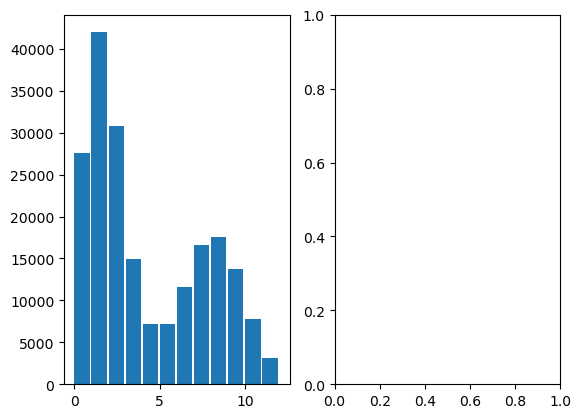

In [121]:
f, ax = plt.subplots(1,2)

# the .flatten() merges all four groups and all 1000 draws into a single long list. 
# So it fits into a histogram much more easily.

predict = predictive_trace.posterior_predictive.error.values.flatten()
ax[0].hist(predict,alpha=1,bins=12,width=0.9,color="tab:blue")

Comparing the predictions to our observed data gives us clues about whether our model is a good explanation.

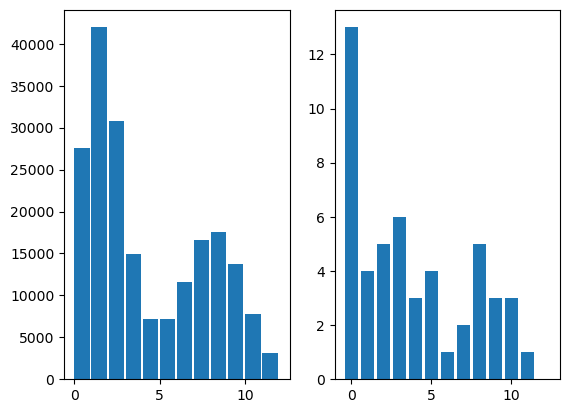

In [122]:
data_sample = list(mistakes_treatment)

# counting structure

outcomes = range(13)
counts = []
    
for i in outcomes:

    matches = data_sample.count(i)
    counts.append(matches)
    
# plotting structure

ax[1].bar(outcomes,counts)
f

What do you think? Does it seem like we have the right model to explain the dataset? Or, does the data have a more complicated structure than we are really picking up here? We'll revisit this question in the unit 2 assignment.

# The Dirichlet distribution

We have one final topic for today. What is that new Dirichlet distribution doing. As usual, we can try to understand it by first looking at its behaviour. I'll use the draw function.

In [123]:
with pm.Model() as explore_dirichlet:
    w = pm.Dirichlet('w',[1,1])

pm.draw(w)

array([0.35778837, 0.64221163])

The Dirichlet is our first *multivariate* distribution. It's output is always two or more numbers in an array. The numbers it generates are bounded between 0 and 1. The sum of all those numbers is always 1. 

The purpose of Dirichlet is to give us an array of weights. In the special case where there are only two, it behaves exactly like the `Beta()` distribution. If we put the parameters around in definition, the control the distribution in the same way a beta - if the sum of the numbers is big, low variance. if the sum the numbers of small, high variance. The ratio of the two numbers controls the mean.

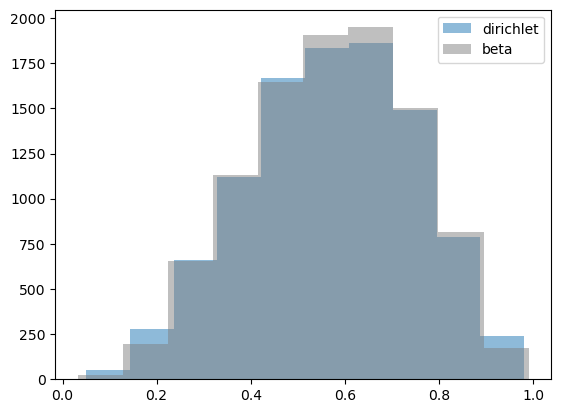

In [130]:
with pm.Model() as explore_dirichlet:
    w0 = pm.Dirichlet('w',[4,3])
    w1 = pm.Beta('w1',4,3)


dirichlet_samples = pm.draw(w0,draws=10000)

# dirichlet always returns two (or more) numbers. 
# this [:,0] ensures we

dirichlet_samples = dirichlet_samples[:,0] 

beta_samples = pm.draw(w1,draws=10000)

plt.hist(dirichlet_samples,alpha=0.5,color="tab:blue",label="dirichlet")
plt.hist(beta_samples,alpha=0.5,color="grey",label="beta")
plt.legend()

However, the Dirichlet can be extended to built weight distributions with more categories. If I want to assign weights to three things while ensuring the weights add up to 1, I can use a model like this.

In [131]:
with pm.Model() as explore_dirichlet:
    w = pm.Dirichlet('w',[1,1,1])

pm.draw(w)

array([0.11376285, 0.57260078, 0.31363637])

The parameters of the Dirichlet behave similarly. If the sum of the numbers is high, the result tightens around an equal split. If one number is bigger than the others, we will tend to get more weight out of that entry. Below, we get three different weights in a histogram. The typical weight is around $\frac{1}{3}$.

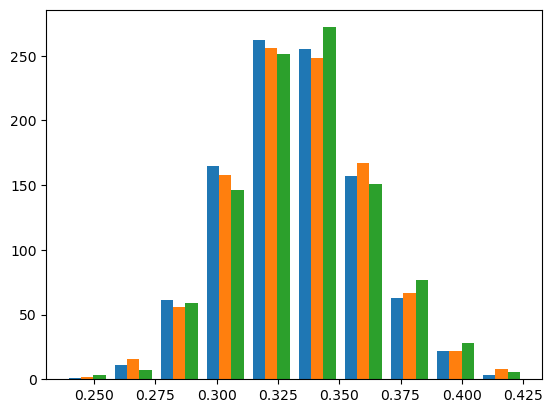

In [133]:
with pm.Model() as explore_dirichlet:
    w = pm.Dirichlet('w',[100,100,100])

draws = pm.draw(w,draws=1000)
plt.hist(draws);

I show you the Dirichlet because it allows our PyMC to generalize easily to cases of 3 component mixtures. If we think there are three types of participants in our experiment and want to figure out who is who, we need to assign weights to all three. So you'll try playing around with the Dirichlet more in the unit 2 assignment.